In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bayesflow as bf
import tensorflow as tf
import sys
sys.path.append('../../')
from mmd import maximum_mean_discrepancy
from c2st import c2st
import seaborn as sns

/Users/marvin/miniforge3/envs/cmpe/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [6]:
idx = 20

tasks = ['gmm', 'twomoons', 'invkinematics']
simulation_budgets = [512, 1024, 2048, 4096, 8192]
estimators = ['ac', 'nsf', 'cmpe', 'fmpe']

eval_estimators = list(
    set(estimators + ['cmpe10', 'cmpe30', 'fmpe10', 'fmpe30']).difference({'cmpe'})
)

eval_dict = pickle.load(open(f'./computations/eval_dict.pkl', 'rb'))

reference_posteriors = {
    'gmm': pickle.load(open('./data/gmm_reference_posterior_samples.pkl', 'rb')),
    'twomoons': pickle.load(open('./data/twomoons_reference_posterior_samples.pkl', 'rb')),
    'invkinematics': pickle.load(open('./data/invkinematics_reference_posterior_samples.pkl', 'rb')),
}

test_data = {
    'gmm': pickle.load(open('./data/gmm_test_data.pkl', 'rb')),
    'twomoons': pickle.load(open('./data/twomoons_test_data.pkl', 'rb')),
    'invkinematics': pickle.load(open('./data/invkinematics_test_data.pkl', 'rb')),

}

test_data['invkinematics']['sim_data'] = np.flip(test_data['invkinematics']['sim_data'], axis=1)


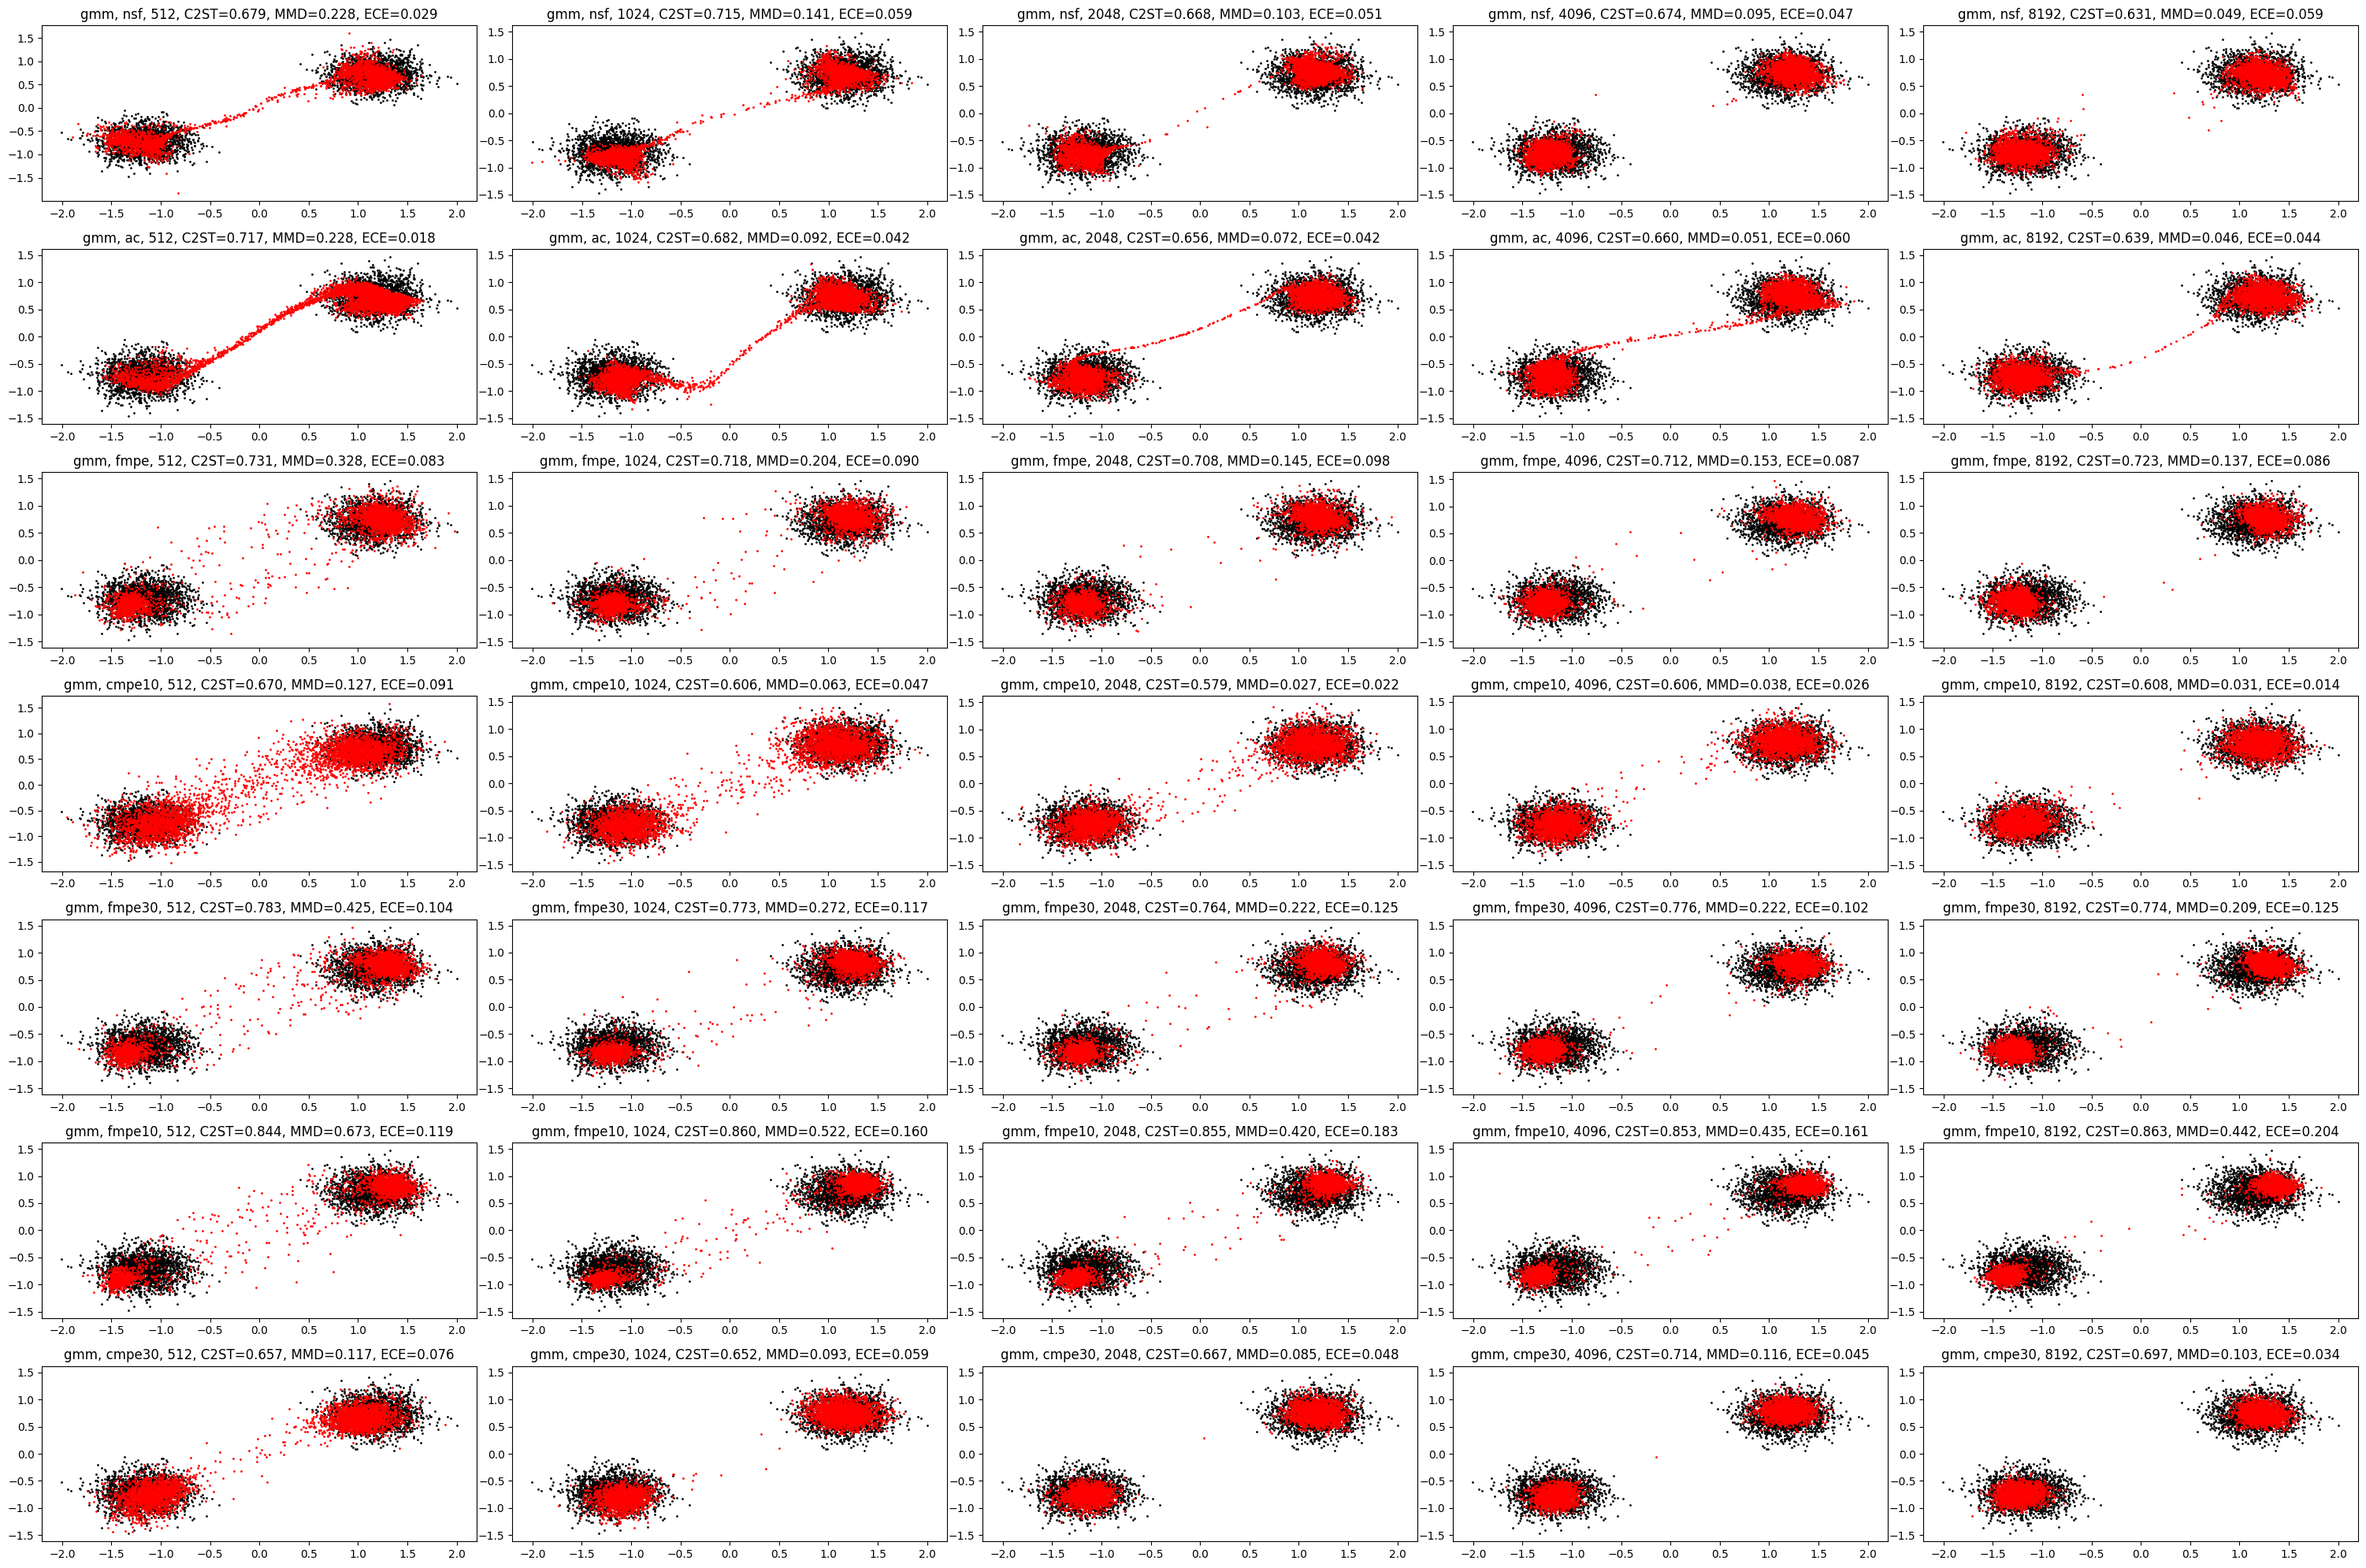

In [3]:
n_test_instances = reference_posteriors['gmm'].shape[0]
assert n_test_instances == reference_posteriors['twomoons'].shape[0]
assert n_test_instances == reference_posteriors['invkinematics'].shape[0]

c2st_dict = {task: {budget: {estimator: {} for estimator in eval_estimators} for budget in simulation_budgets} for task in tasks}
total = len(tasks) * len(simulation_budgets) * len(eval_estimators)

f, ax = plt.subplots(len(eval_estimators), len(simulation_budgets), figsize=(30, 20))

for task in tasks:
    for i, estimator in enumerate(eval_estimators):
        for j, budget in enumerate(simulation_budgets):
            reference = reference_posteriors[task][idx, :]
            approximate = eval_dict[task][budget][estimator]['posterior_samples'][idx, :]
            ground_truth = test_data[task]['prior_draws']
            ax[i, j].scatter(reference[..., 0], reference[..., 1], s=1, c='k')
            ax[i, j].scatter(approximate[...,0], approximate[..., 1], s=1, c='r')
            c2st_val = c2st(reference, approximate, seed=0)
            mmd_val = maximum_mean_discrepancy(reference, approximate, kernel='inverse_multiquadratic')
            calibration = bf.computational_utilities.posterior_calibration_error(eval_dict[task][budget][estimator]['posterior_samples'], test_data[task]['prior_draws'])
            ece = np.max(calibration)
            ax[i, j].set_title(f'{task}, {estimator}, {budget}, C2ST={c2st_val:.3f}, MMD={mmd_val:.3f}, ECE={ece:.3f}')

f.tight_layout()

In [6]:
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

plot_settings = {
    'ac': {'name': 'ACF', 'color': colors[0]},
    'nsf': {'name': 'NSF', 'color': colors[1]},
    'fmpe': {'name': 'FMPE', 'color': colors[5]},
    'fmpe10': {'name': 'FMPE 10#', 'color': colors[2]},
    'fmpe30': {'name': 'FMPE 30#', 'color': colors[4]},
    'cmpe': {'name': 'CMPE', 'color': colors[3]},
    'cmpe10': {'name': 'CMPE 10# (Ours)', 'color': colors[3]},
    'cmpe30': {'name': 'CMPE 30# (Ours)', 'color': colors[6]},
}

In [26]:
from inverse_kinematics import InverseKinematicsModel


def ik_reconstruction_error(posterior_samples, ground_truth):
    n_sim = posterior_samples.shape[0]
    ik_model = InverseKinematicsModel()
    predictions = np.array([ik_model.forward_process(posterior_samples[i, ...]) for i in range(n_sim)])
    squared_difference = (predictions - ground_truth[:, np.newaxis, :])**4
    root_sum_of_squares = np.power(np.sum(squared_difference, axis=2), 1/4)
    return np.mean(root_sum_of_squares, axis=1)

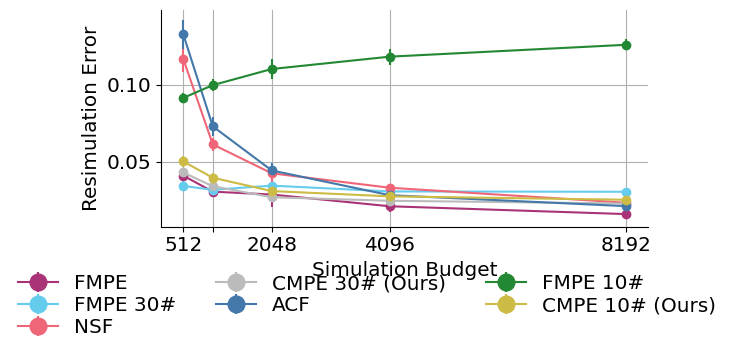

In [28]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))
ground_truth = test_data['invkinematics']['sim_data']
for estimator in eval_estimators:
    error = np.array([ik_reconstruction_error(eval_dict['invkinematics'][budget][estimator]['posterior_samples'], ground_truth) for budget in simulation_budgets])
    ax.errorbar(simulation_budgets, 
                np.mean(error, axis=1), 
                yerr=np.std(error, axis=1)/np.sqrt(100),
                fmt='o-', label=plot_settings[estimator]['name'],
                color = plot_settings[estimator]['color'],)

ax.set_xlabel('Simulation Budget', fontsize='x-large')
ax.set_ylabel('Resimulation Error', fontsize='x-large')


ax.set_xticks([512, 1024, 2048, 4096, 8192])
ax.set_xticklabels(['512', '',  '2048', '4096', '8192'], fontsize='x-large')

# x-large y ticks but dont change them
ax.tick_params(axis='y', which='major', labelsize='x-large')
ax.grid()

lines, labels = plt.gca().get_legend_handles_labels()

# reorder legend: ACF, NSF, CMPE30, FMPE, CMPE10 please
#lines = [lines[1], lines[4], lines[0], lines[3], lines[2]]
#labels = [labels[1], labels[4], labels[0], labels[3], labels[2]]
# legend below plot with 1 row
f.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False, fontsize='x-large', labelspacing=0.15, markerscale=2.0)
sns.despine()
f.tight_layout()
#f.savefig('./figures/simulation_budget_c2st_twomoons.pdf', bbox_inches='tight')

In [7]:
n_eval = 2
for task in tasks:
    for budget in [1024]:
        for estimator in eval_estimators:
            posterior_samples = eval_dict[task][budget][estimator]['posterior_samples'][:n_eval]
            ground_truths = test_data[task]['prior_draws'][:n_eval]
            reference_samples = reference_posteriors[task][:n_eval]

            ece = np.max(bf.computational_utilities.posterior_calibration_error(posterior_samples, ground_truths))
            c2st_val = [c2st(g, r) for g, r in zip(posterior_samples, reference_samples)]
            mmd_val = [maximum_mean_discrepancy(g, r, kernel='inverse_multiquadratic') for g, r in zip(posterior_samples, reference_samples)]

            print(f'{task}, {budget}, {estimator}, {ece:.3f}, {np.mean(c2st_val):.3f}, {np.mean(mmd_val):.3f}')

gmm, 1024, nsf, 0.172, 0.731, 0.217
gmm, 1024, ac, 0.198, 0.746, 0.212
gmm, 1024, fmpe, 0.198, 0.751, 0.266
gmm, 1024, cmpe10, 0.198, 0.639, 0.099
gmm, 1024, fmpe30, 0.172, 0.759, 0.306
gmm, 1024, fmpe10, 0.146, 0.804, 0.435
gmm, 1024, cmpe30, 0.250, 0.723, 0.195
twomoons, 1024, nsf, 0.172, 0.663, 0.011
twomoons, 1024, ac, 0.224, 0.683, 0.017
twomoons, 1024, fmpe, 0.161, 0.671, 0.020
twomoons, 1024, cmpe10, 0.172, 0.639, 0.021
twomoons, 1024, fmpe30, 0.213, 0.770, 0.027
twomoons, 1024, fmpe10, 0.276, 0.958, 0.368
twomoons, 1024, cmpe30, 0.198, 0.644, 0.026
invkinematics, 1024, nsf, 0.344, 0.709, 0.040
invkinematics, 1024, ac, 0.328, 0.707, 0.054
invkinematics, 1024, fmpe, 0.432, 0.693, 0.105
invkinematics, 1024, cmpe10, 0.432, 0.703, 0.063
invkinematics, 1024, fmpe30, 0.432, 0.885, 0.125
invkinematics, 1024, fmpe10, 0.432, 0.894, 0.175
invkinematics, 1024, cmpe30, 0.448, 0.718, 0.086
